In [17]:
import numpy as np
import celerite 
import matplotlib.pyplot as pl
%matplotlib inline

# setup plotting
import seaborn as sns
palette = sns.color_palette()
sns.set()

In [18]:
def two_component_kernel(params):
    a1, b1, a2, b2, c1, sig = params
    S01 = a1*np.sqrt(np.pi/2.)
    S02 = a2*np.sqrt(np.pi/2.)
    Q = 1./np.sqrt(c1 + 2)
    omega01 = 2*np.pi/b1
    omega02 = 2*np.pi/b2
    k = celerite.terms.SHOTerm(log_S0=np.log(S01), log_Q=np.log(Q), log_omega0=np.log(omega01)) + \
        celerite.terms.SHOTerm(log_S0=np.log(S02), log_Q=np.log(1/np.sqrt(2)), log_omega0=np.log(omega02)) +\
        celerite.terms.JitterTerm(log_sigma=np.log(sig))
    return k

# gp parameters for a two-component fit to the power spectrum of Kepler-62
gp_params = 6.34804020e+06, 3.38984805e+05,  6.12139172e+04, 3.38984805e+04, 0, 1e-2
mean = 48670
gp = celerite.GP(two_component_kernel(gp_params), mean=mean, fit_mean=True)

Think about normalizing the light curves. Should I normalize before or after computing an LC for each wavelength? Should I normalize at all? 

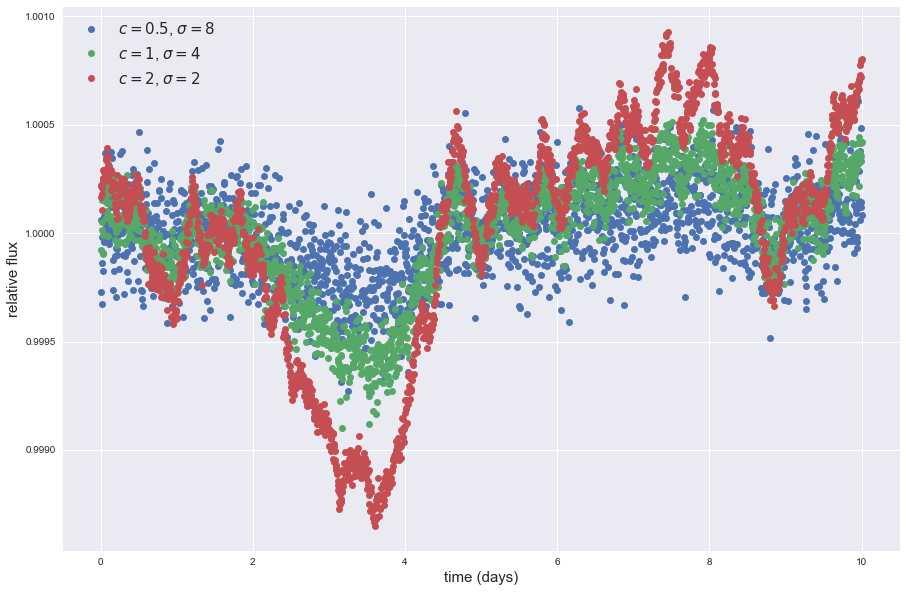

In [31]:
# sample the GP at times t
t = np.linspace(0, 10, 2000)
gp.compute(t*60*60*24)
samp = gp.sample()

# define the coefficients and white noise amplitudes for each band
c = np.tile(np.array([0.5, 1, 2]), (len(t), 1)).T
sig = np.tile(np.array([8, 4, 2]), (len(t), 1)).T
white_noise = np.random.randn(3, len(t))

# compute the flux in each band from the underlying GP sample
flux = c*samp + sig*white_noise

# normalize the fluxes to mean of 1
flux = [(f - np.mean(f))/mean + 1 for f in flux]

# normalize the underlying GP sample to mean of 1 
samp = (samp - np.mean(samp))/mean + 1

# plot the flux in each band
fig = pl.figure(figsize=(15, 10))
pl.plot(t, flux[0], 'o', label=r'$c=0.5$, $\sigma=8$')
pl.plot(t, flux[1], 'o', label=r'$c=1$, $\sigma=4$')
pl.plot(t, flux[2], 'o', label=r'$c=2$, $\sigma=2$')
pl.xlabel('time (days)', size=15)
pl.ylabel('relative flux', size=15)
pl.legend(fontsize=15)

(-0.0003, 0.0003)

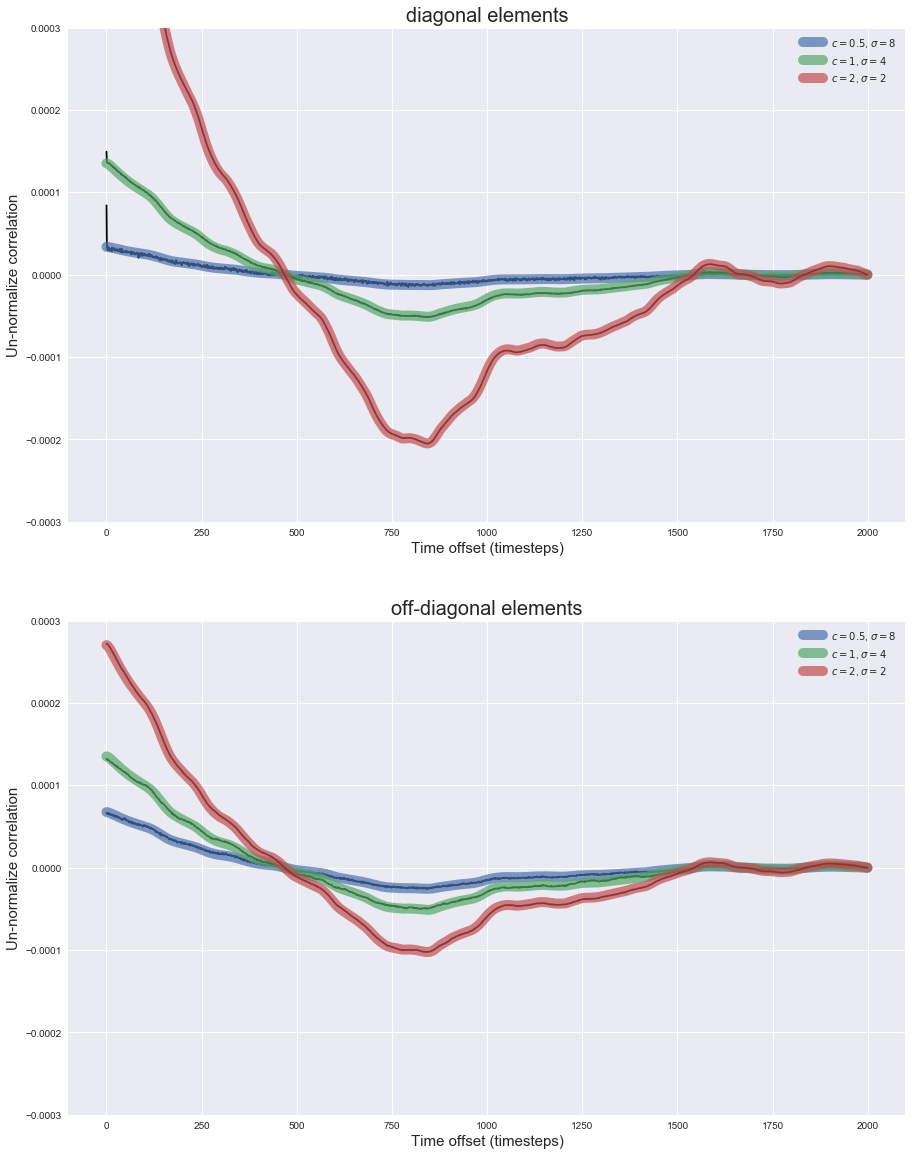

In [34]:
# compute the sum of deviations from the mean over time with offset delta
def sum_over_deviations(F1, F2, delta):
    mu1 = np.mean(F1)
    mu2 = np.mean(F2)
    if delta is not 0:
        return np.sum((F1[:-delta]-mu1)*(F2[delta:]-mu2))
    else:
        return np.sum((F1-mu1)*(F2-mu2))

acf = [sum_over_deviations(samp, samp, i) for i in range(len(t))]

fig, axs = pl.subplots(2, 1, figsize=(15, 20))

axs[0].set_title('diagonal elements', size=20)
axs[0].plot([sum_over_deviations(flux[0], flux[0], i) for i in range(len(t))], color='k')
axs[0].plot(c[0]*c[0]*acf, linewidth=10, alpha=0.7, color=palette[0], label=r'$c=0.5$, $\sigma=8$')

axs[0].plot([sum_over_deviations(flux[1], flux[1], i) for i in range(len(t))], color='k')
axs[0].plot(c[1]*c[1]*acf, linewidth=10, alpha=0.7, color=palette[1], label=r'$c=1$, $\sigma=4$')

axs[0].plot([sum_over_deviations(flux[2], flux[2], i) for i in range(len(t))], color='k')
axs[0].plot(c[2]*c[2]*acf, linewidth=10, alpha=0.7, color=palette[2], label=r'$c=2$, $\sigma=2$')
axs[0].legend()
axs[0].set_xlabel('Time offset (timesteps)', size=15)
axs[0].set_ylabel('Un-normalize correlation', size=15)

axs[1].set_title('off-diagonal elements', size=20)

axs[1].plot([sum_over_deviations(flux[0], flux[1], i) for i in range(len(t))], color='k')
axs[1].plot(c[0]*c[1]*acf, linewidth=10, alpha=0.7, color=palette[0], label=r'$c=0.5$, $\sigma=8$')

axs[1].plot([sum_over_deviations(flux[0], flux[2], i) for i in range(len(t))], color='k')
axs[1].plot(c[0]*c[2]*acf, linewidth=10, alpha=0.7, color=palette[1], label=r'$c=1$, $\sigma=4$')

axs[1].plot([sum_over_deviations(flux[1], flux[2], i) for i in range(len(t))], color='k')
axs[1].plot(c[1]*c[2]*acf, linewidth=10, alpha=0.7, color=palette[2], label=r'$c=2$, $\sigma=2$')
axs[1].legend()
axs[1].set_xlabel('Time offset (timesteps)', size=15)
axs[1].set_ylabel('Un-normalize correlation', size=15)

axs[0].set_ylim(-0.0003, 0.0003)
axs[1].set_ylim(-0.0003, 0.0003)